# Modeling

Will be trying 3 models: logistic regression, Random Forest, and SGD.

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Display all columns
pd.set_option('display.max_columns', None)
# Customize column names
col_names = ['ID','Diagnosis','radius','texture','perimeter','area','smoothness','compactness',
             'concavity','concave_pts','symmetry','fractal_dim','radius_std','texture_std',
             'perimeter_std','area_std', 'smoothness_std','compactness_std','concavity_std',
             'concave_pts_std','symmetry_std','fractal_dim_std','radius_ext','texture_ext',
             'perimeter_ext','area_ext','smoothness_ext','compactness_ext','concavity_ext',
             'concave_pts_ext','symmetry_ext','fractal_dim_ext']
# Import data
df = pd.read_table('wdbc.data',sep=',',names = col_names)

In [3]:
# Recreating train/test split
tts_df = df.drop('ID', axis = 1)
tts_df['Diagnosis'] = tts_df['Diagnosis'].replace(to_replace = {'M': 1, 'B': 0})

# Splitting into train and test sets - will be the same as for modelling
X = tts_df.drop('Diagnosis', axis = 1)
y = tts_df.Diagnosis

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 17)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 30), (455,), (114, 30), (114,))

In [4]:
# Prepare subsets for modelling
full = ['radius','texture','perimeter','area','smoothness','compactness','concavity',
        'concave_pts','symmetry','fractal_dim','radius_std','texture_std','perimeter_std',
        'area_std', 'smoothness_std','compactness_std','concavity_std','concave_pts_std',
        'symmetry_std','fractal_dim_std','radius_ext','texture_ext','perimeter_ext','area_ext',
        'smoothness_ext','compactness_ext','concavity_ext','concave_pts_ext','symmetry_ext',
        'fractal_dim_ext']
# Removed area
subset1 = ['radius','texture','perimeter','smoothness','compactness','concavity','concave_pts',
           'symmetry','fractal_dim','radius_std','texture_std','perimeter_std','smoothness_std',
           'compactness_std','concavity_std','concave_pts_std','symmetry_std','fractal_dim_std',
           'radius_ext','texture_ext','perimeter_ext','smoothness_ext','compactness_ext',
           'concavity_ext','concave_pts_ext','symmetry_ext','fractal_dim_ext']
# Removed radius, area, compactness, concavity, and concave_pts
subset2 = ['texture','perimeter','smoothness','symmetry','fractal_dim','texture_std','perimeter_std',
           'smoothness_std','symmetry_std','fractal_dim_std','texture_ext','perimeter_ext',
           'smoothness_ext','symmetry_ext','fractal_dim_ext']
# Removed standard errors - still unsure as to whether these should be useful
subset3 = ['radius','texture','perimeter','smoothness','compactness','concavity','concave_pts',
           'symmetry','fractal_dim','radius_ext','texture_ext','perimeter_ext','smoothness_ext',
           'compactness_ext','concavity_ext','concave_pts_ext','symmetry_ext','fractal_dim_ext']
# PCA components top 13 features
subset4 = ['concavity_std','concave_pts','fractal_dim','texture_std','smoothness','symmetry_ext',
           'fractal_dim_ext','smoothness_std','symmetry','symmetry_std','concavity','compactness_std']
# RF permutation top 6 features (feature and permutation importance combined)
subset5 = ['concave_pts_ext', 'perimeter_ext', 'radius_ext', 'concavity', 'radius', 
           'concavity_ext', 'area']

In [5]:
# Baseline performance
logreg = LogisticRegression(max_iter = 2150, random_state = 17).fit(X_train, y_train)
logpred = logreg.predict(X_test)
logp1 = precision_score(y_test, logpred)
logr1 = round(recall_score(y_test, logpred), 3)

sgd = SGDClassifier(random_state = 17).fit(X_train, y_train)
sgdpred = sgd.predict(X_test)
sgdp1 = round(precision_score(y_test, sgdpred), 3)
sgdr1 = round(recall_score(y_test, sgdpred), 3)

forest = RandomForestClassifier(random_state = 17).fit(X_train, y_train)
forestpred = forest.predict(X_test)
forestp1 = round(precision_score(y_test, forestpred), 5)
forestr1 = round(recall_score(y_test, forestpred), 5)

print('Logistic regression - baseline:\nPrecision:', logp1, '\nRecall:', logr1)
print('\nStochastic GD - baseline:\nPrecision:', sgdp1, '\nRecall:', sgdr1)
print('\nRandom Forest - baseline:\nPrecision:', forestp1, '\nRecall:', forestr1)

Logistic regression - baseline:
Precision: 0.9 
Recall: 0.947

Stochastic GD - baseline:
Precision: 0.969 
Recall: 0.816

Random Forest - baseline:
Precision: 0.94737 
Recall: 0.94737


SGD is the weakest in terms of recall. Will start by trying to tune this one.

# SGD

In [6]:
# SGD grid search
interest = ['param_loss', 'param_penalty', 'mean_test_f1', 'mean_test_precision',
            'mean_test_recall', 'mean_test_roc_auc']

params = {'loss': ['hinge','modified_huber','log_loss'],
         'penalty': ['l2','l1','elasticnet']}

sgd_gs = GridSearchCV(sgd, param_grid = params, scoring = ['f1','precision','recall','roc_auc'],
                     n_jobs = -1, refit = False, return_train_score = True)
cv_fit = sgd_gs.fit(X_train, y_train)
cv_res = pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_recall', ascending = False)[0:5]
cv_res.loc[:, interest]

,param_loss,param_penalty,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc
1,hinge,l1,0.850578,0.830911,0.890588,0.964877
5,modified_huber,elasticnet,0.809554,0.778814,0.890420,0.960167
8,log_loss,elasticnet,0.809554,0.778814,0.890420,0.960167
2,hinge,elasticnet,0.871335,0.882976,0.878319,0.962685
4,modified_huber,l1,0.830438,0.832116,0.868067,0.957435


In [7]:
# SGD scores
sgd_best = SGDClassifier(loss = 'hinge', penalty = 'l1', random_state = 17).fit(X_train, y_train)
sgd_bestpred = sgd_best.predict(X_test)

sgd_bestroc1 = round(roc_auc_score(y_test, sgd_bestpred), 4)
sgd_bestp1 = round(precision_score(y_test, sgd_bestpred), 4)
sgd_bestr1 = round(recall_score(y_test, sgd_bestpred), 4)

print('Stochastic GD - tuned:\nROC-AUC:', sgd_bestroc1,'\nPrecision:', sgd_bestp1, '\nRecall:',
      sgd_bestr1)

Stochastic GD - tuned:
ROC-AUC: 0.8882 
Precision: 0.9118 
Recall: 0.8158


In [8]:
# Test if scaling improves performance
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

scaled_sgd = SGDClassifier(random_state = 17).fit(X_train_s, y_train)
scaled_sgdpred = scaled_sgd.predict(X_test_s)

scaled_sgdroc1 = round(roc_auc_score(y_test, scaled_sgdpred), 4)
scaled_sgdp1 = round(precision_score(y_test, scaled_sgdpred), 5)
scaled_sgdr1 = round(recall_score(y_test, scaled_sgdpred), 5)

print('\nStochastic GD - baseline scaled:\nROC-AUC:', scaled_sgdroc1, '\nPrecision:', scaled_sgdp1, '\nRecall:', scaled_sgdr1)


Stochastic GD - baseline scaled:
ROC-AUC: 0.9474 
Precision: 1.0 
Recall: 0.89474


In [9]:
# Running grid search again on scaled training data
interest = ['param_loss', 'param_penalty', 'mean_test_f1', 'mean_test_precision',
            'mean_test_recall', 'mean_test_roc_auc']

params = {'loss': ['hinge','modified_huber','log_loss'],
         'penalty': ['l2','l1','elasticnet']}

sgd_gs = GridSearchCV(scaled_sgd, param_grid = params, scoring = ['f1','precision','recall','roc_auc'],
                     n_jobs = -1, refit = False, return_train_score = True)
cv_fit = sgd_gs.fit(X_train_s, y_train)
cv_res = pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_recall', ascending = False)[0:5]
cv_res.loc[:, interest]

,param_loss,param_penalty,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc
5,modified_huber,elasticnet,0.955082,0.941553,0.971092,0.997951
3,modified_huber,l2,0.954372,0.945142,0.965210,0.996299
6,log_loss,l2,0.959922,0.956244,0.965210,0.997120
0,hinge,l2,0.946397,0.936649,0.959496,0.995577
2,hinge,elasticnet,0.956944,0.955926,0.959496,0.996917


In [10]:
# Check model performance with new hyperparameters
sgd_scaled = SGDClassifier(loss = 'modified_huber', penalty = 'elasticnet', random_state = 17).fit(X_train_s, y_train)
sgd_scaledpred = sgd_scaled.predict(X_test_s)

sgd_scaledroc1 = round(roc_auc_score(y_test, sgd_scaledpred), 4)
sgd_scaledp1 = round(precision_score(y_test, sgd_scaledpred), 4)
sgd_scaledr1 = round(recall_score(y_test, sgd_scaledpred), 4)

print('Stochastic GD - cv, scaled:\nROC-AUC:', sgd_scaledroc1, '\nPrecision:', sgd_scaledp1,
      '\nRecall:', sgd_scaledr1)

Stochastic GD - cv, scaled:
ROC-AUC: 0.9342 
Precision: 0.9444 
Recall: 0.8947


8% improvement in recall over unscaled SGD model. Add learning rate?

In [11]:
# SGD grid search - added learning rate
interest = ['param_learning_rate', 'param_eta0', 'param_loss', 'param_penalty', 'mean_test_f1', 'mean_test_precision',
            'mean_test_recall', 'mean_test_roc_auc']

params = {'loss': ['hinge','modified_huber','log_loss'], 'penalty': ['l2','l1','elasticnet'],
          'learning_rate': ['optimal','invscaling','adaptive'],
          'eta0': np.linspace(.01, 1, 10)}
                            
sgd_gs = GridSearchCV(sgd_scaled, param_grid = params, scoring = ['f1','precision','recall','roc_auc'],
                     n_jobs = -1, refit = False, return_train_score = True)
cv_fit = sgd_gs.fit(X_train_s, y_train)
cv_res = pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_recall', ascending = False)[0:5]

In [12]:
cv_res.loc[:, interest]

,param_learning_rate,param_eta0,param_loss,param_penalty,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc
221,optimal,0.89,modified_huber,elasticnet,0.955082,0.941553,0.971092,0.997951
259,invscaling,1.0,log_loss,l1,0.968428,0.966162,0.971092,0.997951
32,optimal,0.12,modified_huber,elasticnet,0.955082,0.941553,0.971092,0.997951
86,optimal,0.34,modified_huber,elasticnet,0.955082,0.941553,0.971092,0.997951
231,invscaling,0.89,log_loss,l2,0.968428,0.966162,0.971092,0.997951


In [13]:
# Check model performance with new hyperparameters
sgd_final = SGDClassifier(learning_rate = 'optimal', eta0 = .34, loss = 'modified_huber',
                          penalty = 'elasticnet', random_state = 17).fit(X_train_s, y_train)
sgd_finalpred = sgd_final.predict(X_test_s)

sgd_finalroc1 = round(roc_auc_score(y_test, sgd_finalpred), 4)
sgd_finalp1 = round(precision_score(y_test, sgd_finalpred), 4)
sgd_finalr1 = round(recall_score(y_test, sgd_finalpred), 4)

print('Stochastic GD - tuned w/lr, scaled:\nROC-AUC:', sgd_finalroc1, '\nPrecision:',
      sgd_finalp1, '\nRecall:', sgd_finalr1)

Stochastic GD - tuned w/lr, scaled:
ROC-AUC: 0.9342 
Precision: 0.9444 
Recall: 0.8947


No difference with learning rate added.

# Logistic regression

In [ ]:
# Logistic regression grid search
interest = ['param_C', 'param_max_iter', 'param_penalty', 'param_solver', 'mean_test_f1',
            'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc']

c = np.linspace(.1, 1000, 10)
params = {'penalty': ['l2','l1','elasticnet'], 'C': c, 'max_iter': [28, 100, 1000],
          'solver': ['lbfgs','newton-cg','sag','saga']}

log_gs = GridSearchCV(logreg, param_grid = params, scoring = ['f1','precision','recall','roc_auc'],
                     n_jobs = -1, refit = False, return_train_score = True)
cv_fit = log_gs.fit(X_train, y_train)
cv_res = pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_roc_auc', ascending = False)[0:5]

In [15]:
cv_res.loc[:, interest]

,param_C,param_max_iter,param_penalty,param_solver,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc
277,777.8,1000,l2,newton-cg,0.956214,0.965401,0.947899,0.994142
313,888.9,1000,l2,newton-cg,0.956214,0.965401,0.947899,0.994141
349,1000.0,1000,l2,newton-cg,0.953627,0.960565,0.947899,0.994141
241,666.7,1000,l2,newton-cg,0.956214,0.965401,0.947899,0.993936
301,888.9,100,l2,newton-cg,0.956214,0.965401,0.947899,0.993934


In [16]:
# Check model performance with new hyperparameters
log_best = LogisticRegression(C = 777.8, max_iter = 1000, solver = 'newton-cg', penalty = 'l2',
                             random_state = 17).fit(X_train, y_train)
log_bestpred = log_best.predict(X_test)
log_bestroc1 = round(roc_auc_score(y_test, log_bestpred), 4)
log_bestp1 = round(precision_score(y_test, log_bestpred), 4)
log_bestr1 = round(recall_score(y_test, log_bestpred), 4)

print('Logistic regression - baseline:\nPrecision:', logp1, '\nRecall:', logr1)

print('\nLogistic regression - tuned:\nROC-AUC:', log_bestroc1, '\nPrecision:', log_bestp1,
      '\nRecall:', log_bestr1)

Logistic regression - baseline:
Precision: 0.9 
Recall: 0.947

Logistic regression - tuned:
ROC-AUC: 0.9539 
Precision: 0.9231 
Recall: 0.9474


Slight improvement in precision, no change in recall.

# Random Forest

In [17]:
# Random Forest grid search
interest = ['param_bootstrap', 'param_criterion', 'param_max_depth', 'param_max_features',
            'param_n_estimators', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall',
            'mean_test_roc_auc']

params = {'n_estimators': [10, 20, 50, 100], 'criterion': ['gini','entropy','log_loss'],
         'max_depth': [None, 3, 5, 10], 'max_features': [None,'sqrt','log2'],
          'bootstrap': [True, False]}

forest_gs = GridSearchCV(forest, param_grid = params, scoring = ['f1','precision','recall','roc_auc'],
                     n_jobs = -1, refit = False, return_train_score = True)
cv_fit = forest_gs.fit(X_train, y_train)
cv_res = pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_recall', ascending = False)[0:5]
cv_res.loc[:, interest]

,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc
77,True,entropy,5,sqrt,20,0.959246,0.961066,0.959328,0.994374
125,True,log_loss,5,sqrt,20,0.959246,0.961066,0.959328,0.994374
287,False,log_loss,10,log2,100,0.956464,0.962962,0.953613,0.994576
190,False,gini,10,log2,50,0.953510,0.956228,0.953613,0.994475
239,False,entropy,10,log2,100,0.956464,0.962962,0.953613,0.994576


In [18]:
rf_best = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth = 5,
                                 max_features = 'sqrt', n_estimators = 20, random_state = 17).fit(X_train, y_train)

rf_bestpred = rf_best.predict(X_test)
rf_bestroc1 = round(roc_auc_score(y_test, rf_bestpred), 4)
rf_bestp1 = round(precision_score(y_test, rf_bestpred), 4)
rf_bestr1 = round(recall_score(y_test, rf_bestpred), 4)

print('\nRandom Forest - baseline:\nPrecision:', forestp1, '\nRecall:', forestr1)
print('\nRandom Forest - tuned:\nROC-AUC:', rf_bestroc1, '\nPrecision:', rf_bestp1,
      '\nRecall:', rf_bestr1)


Random Forest - baseline:
Precision: 0.94737 
Recall: 0.94737

Random Forest - tuned:
ROC-AUC: 0.9539 
Precision: 0.9231 
Recall: 0.9474


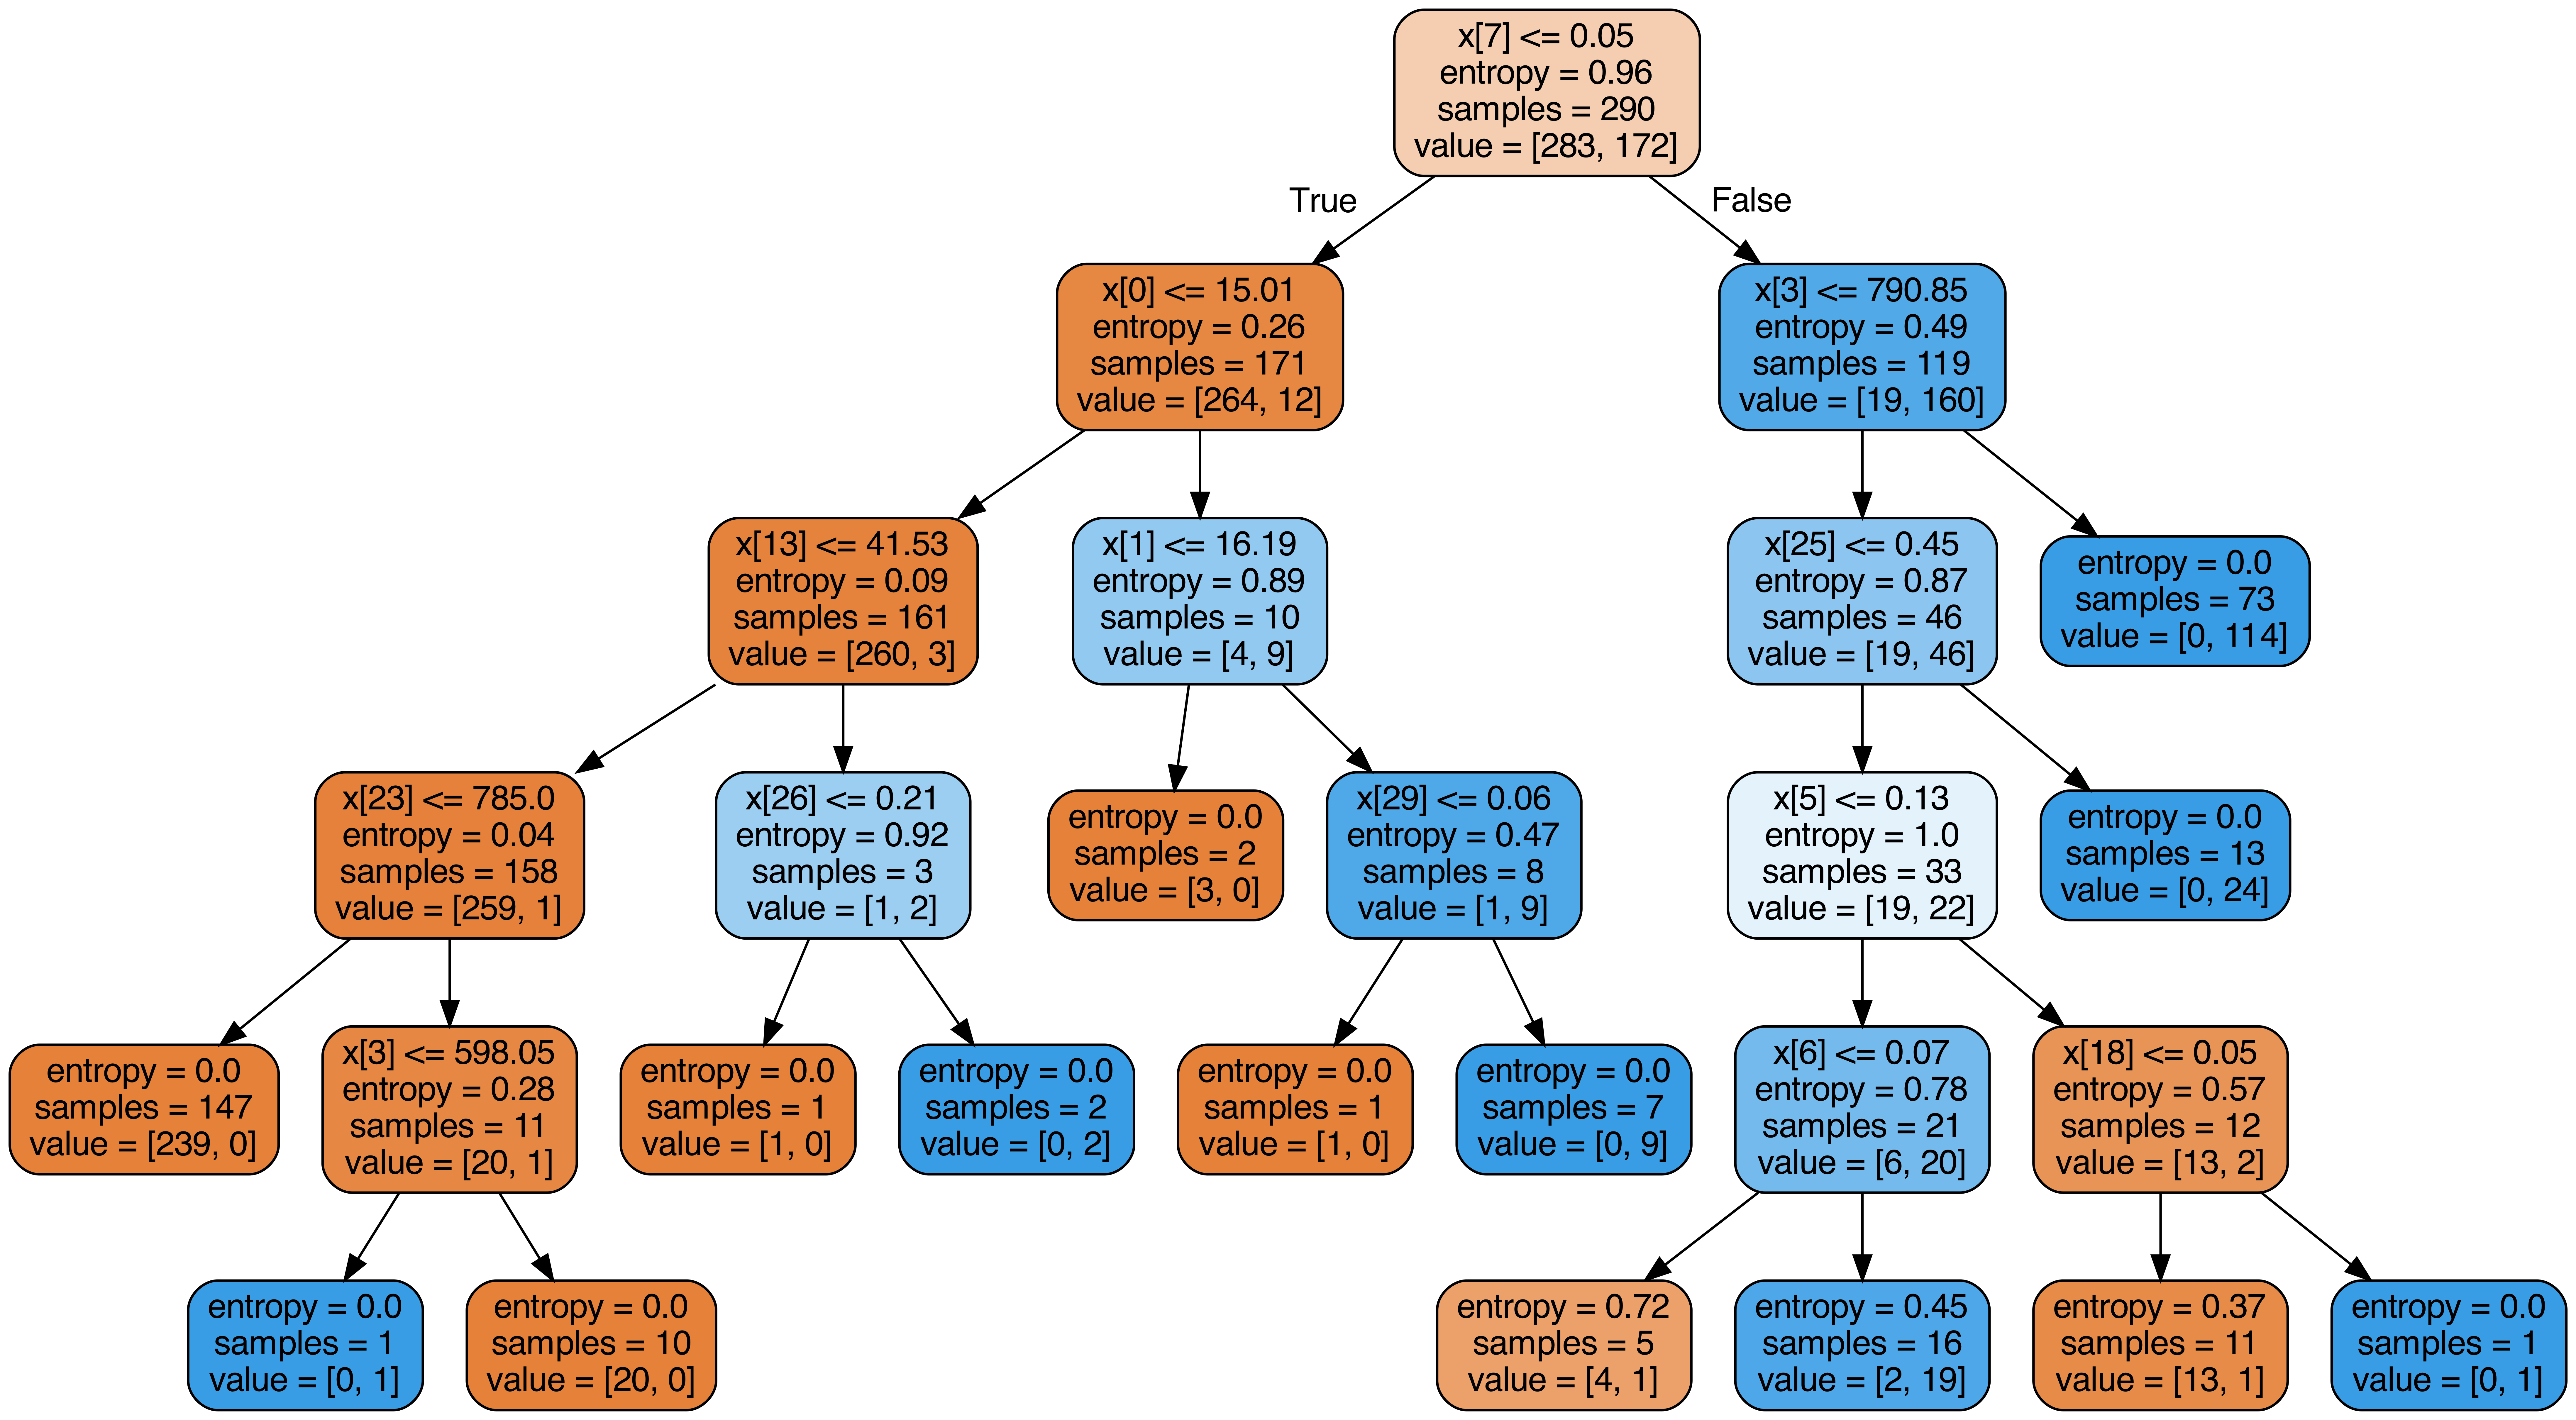

In [19]:
# Display one tree
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

estimator = rf_best.estimators_[5]

export_graphviz(estimator, out_file = 'tree.dot', rounded = True, proportion = False,
               precision = 2, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

log_best, sgd_final, rf_best

# Selection

In [20]:
display('Log regression:', pd.DataFrame(classification_report(y_test, log_bestpred, output_dict=True)),
        'SGD:', pd.DataFrame(classification_report(y_test, sgd_finalpred, output_dict=True)),
        'Random Forest:', pd.DataFrame(classification_report(y_test, rf_bestpred, output_dict=True)))

'Log regression:'

,0,1,accuracy,macro avg,weighted avg
precision,0.973333,0.923077,0.95614,0.948205,0.956581
recall,0.960526,0.947368,0.95614,0.953947,0.956140
f1-score,0.966887,0.935065,0.95614,0.950976,0.956280
support,76.000000,38.000000,0.95614,114.000000,114.000000


'SGD:'

,0,1,accuracy,macro avg,weighted avg
precision,0.948718,0.944444,0.947368,0.946581,0.947293
recall,0.973684,0.894737,0.947368,0.934211,0.947368
f1-score,0.961039,0.918919,0.947368,0.939979,0.946999
support,76.000000,38.000000,0.947368,114.000000,114.000000


'Random Forest:'

,0,1,accuracy,macro avg,weighted avg
precision,0.973333,0.923077,0.95614,0.948205,0.956581
recall,0.960526,0.947368,0.95614,0.953947,0.956140
f1-score,0.966887,0.935065,0.95614,0.950976,0.956280
support,76.000000,38.000000,0.95614,114.000000,114.000000


(-300.0, 300.0)

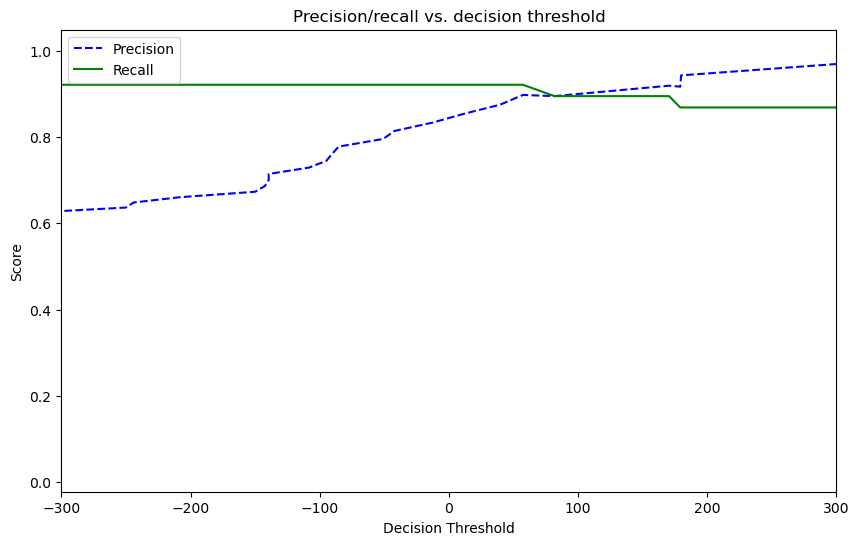

In [23]:
# Define function for precision-recall plotting
def plot_pr_thr(precisions, recalls, thresholds):
    plt.figure(figsize=(10,6))
    plt.title("Precision/recall vs. decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

# Precision-recall curve - SGD
sgd_scores = cross_val_predict(sgd_scaled, X_test_s, y_test, cv = 3, method = 'decision_function')

p, r, th = precision_recall_curve(y_test, sgd_scores)
plot_pr_thr(p, r, th)
plt.xlim(-300, 300)

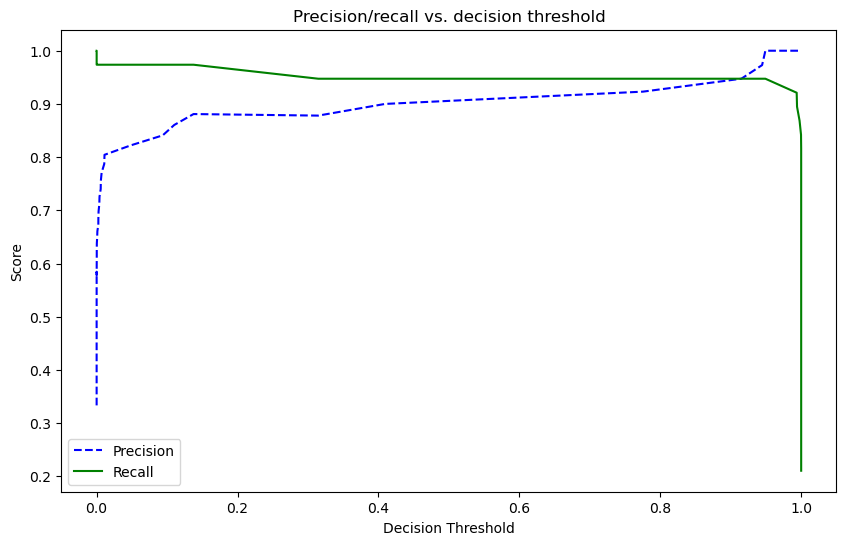

In [24]:
# Precision-recall curve - logistic regression
log_scores = log_best.predict_proba(X_test)[:, 1]
pl, rl, tl = precision_recall_curve(y_test, log_scores)
plot_pr_thr(pl, rl, tl)

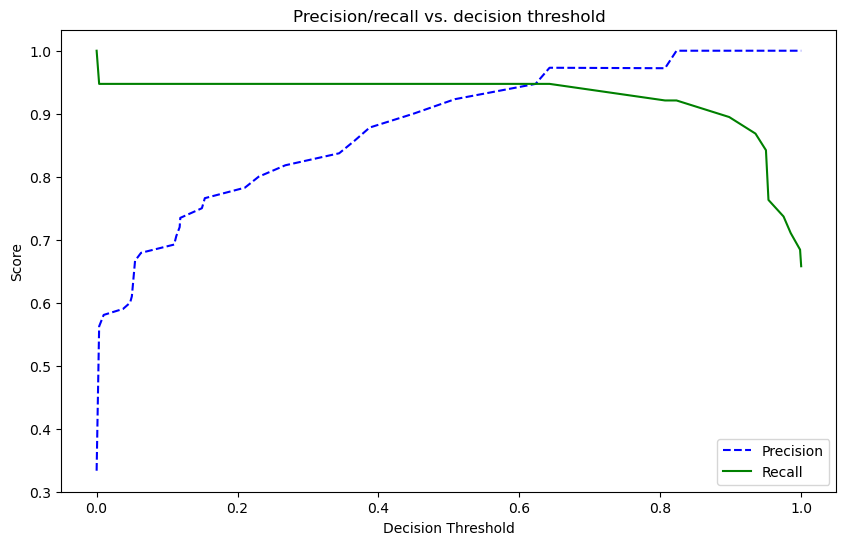

In [25]:
# Precision-recall curve - Random Forest
rf_scores = rf_best.predict_proba(X_test)[:, 1]
pr, rr, tr = precision_recall_curve(y_test, rf_scores)
plot_pr_thr(pr, rr, tr)

SGD AUC: 0.9480609418282548


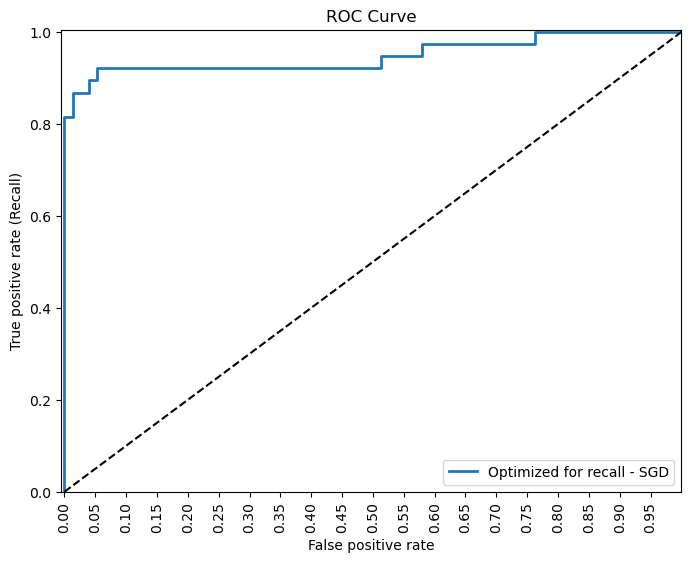

In [26]:
# Define function for ROC curve plotting
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize = (8,6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation = 90)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate (Recall)")
    plt.legend(loc = 'lower right')

# ROC - SGD
fpr, tpr, auc_thresholds = roc_curve(y_test, sgd_scores)
print('SGD AUC:', auc(fpr, tpr))
plot_roc_curve(fpr, tpr, 'Optimized for recall - SGD')

Log AUC: 0.9889196675900278


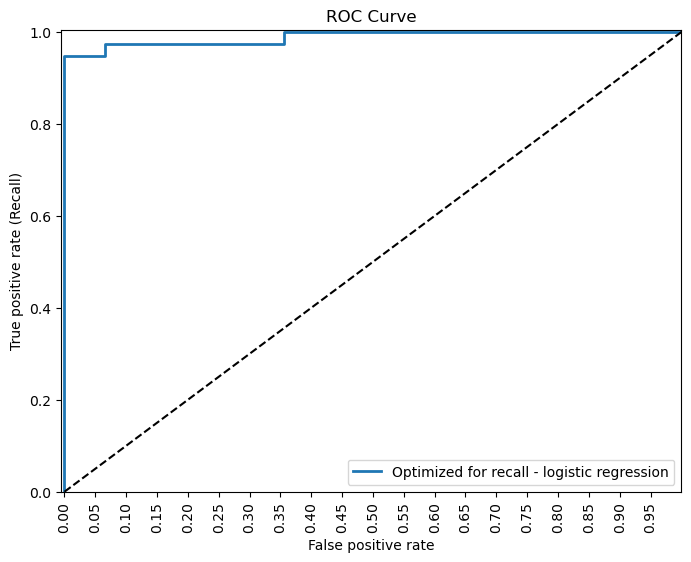

In [27]:
# ROC - logistic regression
fpr, tpr, auc_thresholds = roc_curve(y_test, log_scores)
print('Log AUC:', auc(fpr, tpr))
plot_roc_curve(fpr, tpr, 'Optimized for recall - logistic regression')

RF AUC: 0.9636426592797783


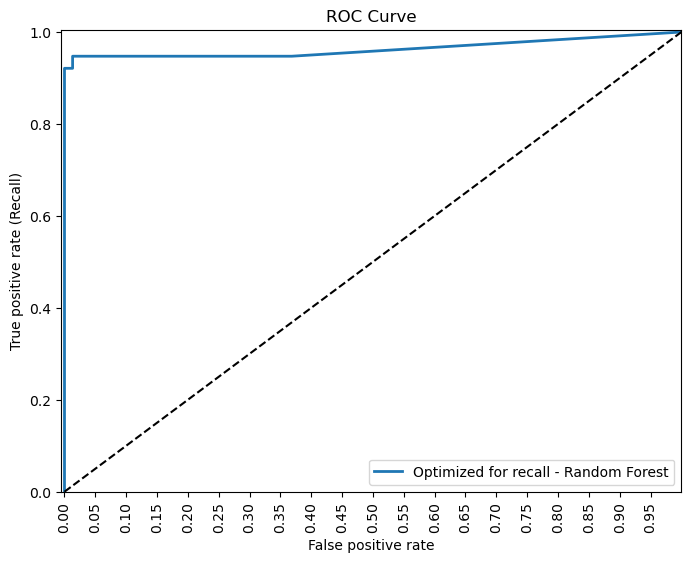

In [28]:
# ROC - Random Forest
fpr, tpr, auc_thresholds = roc_curve(y_test, rf_scores)
print('RF AUC:', auc(fpr, tpr))
plot_roc_curve(fpr, tpr, 'Optimized for recall - Random Forest')

In [29]:
# Cross validating performance on all models
log_cv = cross_validate(log_best, X_train, y_train, cv=5, scoring = ['precision','recall','roc_auc','f1'])
sgd_cv = cross_validate(sgd_scaled, X_train_s, y_train, cv=5, scoring = ['precision','recall','roc_auc','f1'])
rf_cv = cross_validate(rf_best, X_train, y_train, cv=5, scoring = ['precision','recall','roc_auc','f1'])

In [30]:
# Grouping and comparing performance
df_log_cv = pd.DataFrame()

for k, v in log_cv.items():
    df_log_cv[k + '_log'] = v
    
df_sgd_cv = pd.DataFrame()
    
for k, v in sgd_cv.items():
    df_sgd_cv[k + '_sgd'] = v
    
df_rf_cv = pd.DataFrame()

for k, v in rf_cv.items():
    df_rf_cv[k + '_rf'] = v
    
df_cv = pd.concat([df_log_cv, df_sgd_cv, df_rf_cv], axis = 1)
df_cv.drop(labels = ['fit_time_log', 'score_time_log', 'fit_time_sgd', 'score_time_sgd',
                     'fit_time_rf','score_time_rf'], axis = 1, inplace = True)
df_cv

,test_precision_log,test_recall_log,test_roc_auc_log,test_f1_log,test_precision_sgd,test_recall_sgd,test_roc_auc_sgd,test_f1_sgd,test_precision_rf,test_recall_rf,test_roc_auc_rf,test_f1_rf
0,0.937500,0.882353,0.981424,0.909091,0.969697,0.941176,0.996388,0.955224,0.967742,0.882353,0.993808,0.923077
1,0.918919,0.971429,0.994898,0.944444,0.970588,0.942857,0.997449,0.956522,0.970588,0.942857,0.995918,0.956522
2,1.000000,0.971429,1.000000,0.985507,0.875000,1.000000,1.000000,0.933333,0.921053,1.000000,0.995408,0.958904
3,1.000000,0.971429,0.997959,0.985507,0.921053,1.000000,0.999490,0.958904,0.945946,1.000000,0.994133,0.972222
4,0.970588,0.942857,0.996429,0.956522,0.971429,0.971429,0.996429,0.971429,1.000000,0.971429,0.992602,0.985507


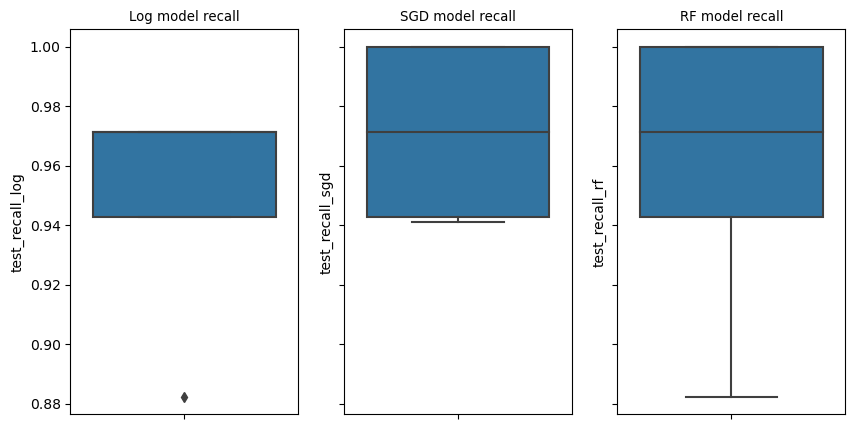

In [31]:
# Examining performance variance for each model - recall
fig,ax = plt.subplots(1, 3, figsize = (10,5), sharey = True)
plt.rcParams['font.size'] = 8

sns.boxplot(ax = ax[0], y = 'test_recall_log', data = df_cv)
ax[0].set_title('Log model recall')
sns.boxplot(ax = ax[1], y = 'test_recall_sgd', data = df_cv)
ax[1].set_title('SGD model recall')
sns.boxplot(ax = ax[2], y = 'test_recall_rf', data = df_cv)
ax[2].set_title('RF model recall');

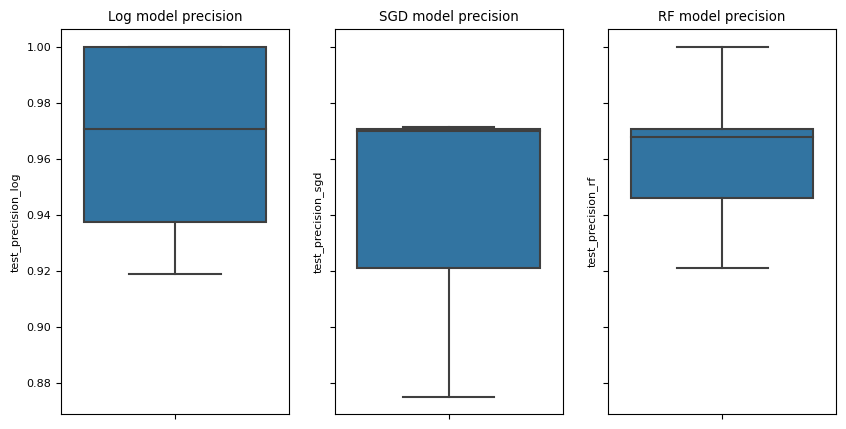

In [32]:
# Examining performance variance for each model - precision
fig,ax = plt.subplots(1, 3, figsize = (10,5), sharey = True)
plt.rcParams['font.size'] = 8
sns.boxplot(ax = ax[0], y = 'test_precision_log', data = df_cv)
ax[0].set_title('Log model precision')
sns.boxplot(ax = ax[1], y = 'test_precision_sgd', data = df_cv)
ax[1].set_title('SGD model precision')
sns.boxplot(ax = ax[2], y = 'test_precision_rf', data = df_cv)
ax[2].set_title('RF model precision');

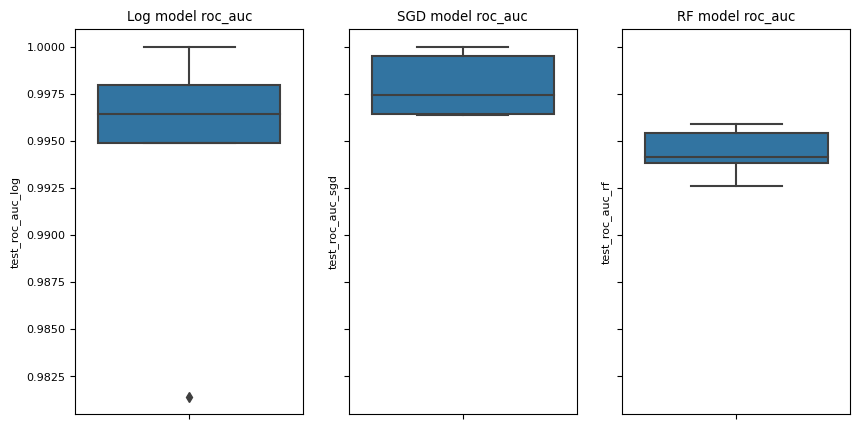

In [33]:
# Examining performance variance for each model - ROC-AUC
fig,ax = plt.subplots(1, 3, figsize = (10,5), sharey = True)
plt.rcParams['font.size'] = 8
sns.boxplot(ax = ax[0], y = 'test_roc_auc_log', data = df_cv)
ax[0].set_title('Log model roc_auc')
sns.boxplot(ax = ax[1], y = 'test_roc_auc_sgd', data = df_cv)
ax[1].set_title('SGD model roc_auc')
sns.boxplot(ax = ax[2], y = 'test_roc_auc_rf', data = df_cv)
ax[2].set_title('RF model roc_auc');

Logistic regression has the weakest recall but good precision and ROC-AUC.
SGD has the weakest precision but good recall and ROC-AUC.
Random Forest has the weakest ROC-AUC but good recall and precision.

ROC-AUC does not show much variation in any model.
Recall is the most important metric in this use case - logistic regression is out.
Random Forest has a higher precision than SGD.

Going with Random Forest - best performing across the most relevant metrics.

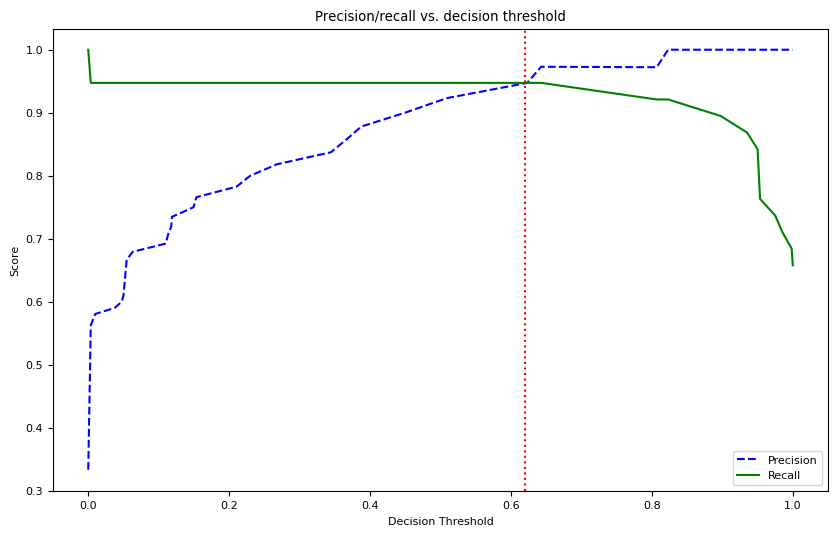

In [34]:
# RF precision-recall curve copied from above
plot_pr_thr(pr, rr, tr)
plt.axvline(x = .62, color = 'red', linestyle = ':')

In [35]:
# Confirming model selection with estimated best thresholds (highest recall)
t57 = (sgd_scores >=57).astype(bool)
t13 = (log_scores >=.13).astype(bool)
t64 = (rf_scores >=.64).astype(bool)

display(pd.DataFrame(classification_report(y_test.astype(bool), t57, output_dict=True)),
        pd.DataFrame(classification_report(y_test.astype(bool), t13, output_dict=True)),
        pd.DataFrame(classification_report(y_test.astype(bool), t64, output_dict=True)))

,False,True,accuracy,macro avg,weighted avg
precision,0.960000,0.897436,0.938596,0.928718,0.939145
recall,0.947368,0.921053,0.938596,0.934211,0.938596
f1-score,0.953642,0.909091,0.938596,0.931367,0.938792
support,76.000000,38.000000,0.938596,114.000000,114.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.986111,0.880952,0.947368,0.933532,0.951058
recall,0.934211,0.973684,0.947368,0.953947,0.947368
f1-score,0.959459,0.925000,0.947368,0.942230,0.947973
support,76.000000,38.000000,0.947368,114.000000,114.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.974026,0.972973,0.973684,0.973499,0.973675
recall,0.986842,0.947368,0.973684,0.967105,0.973684
f1-score,0.980392,0.960000,0.973684,0.970196,0.973595
support,76.000000,38.000000,0.973684,114.000000,114.000000


- SGD model - 89.7 / 92.1
- Log model - 88.1 / 97.4
- RF model - 97.3 / 94.7

Model selection confirmed - SGD and logistic regression sacrifice too much precision. Random Forest is overall stronger even though recall is 2.7% lower than logistic regression.

In [36]:
X_train1 = X_train[subset1]
X_train2 = X_train[subset2]
X_train3 = X_train[subset3]
X_train4 = X_train[subset4]
X_train5 = X_train[subset5]

X_test1 = X_test[subset1]
X_test2 = X_test[subset2]
X_test3 = X_test[subset3]
X_test4 = X_test[subset4]
X_test5 = X_test[subset5]

In [37]:
# Recreating model and now testing feature subsets to see if I can improve performance more
rf = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth = 5, max_features = 'sqrt',
                            n_estimators = 20, random_state = 17)

def rf_sub(rf, X_train, X_test):
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    precision = round(precision_score(y_test, pred), 3)
    recall = round(recall_score(y_test, pred), 3)
    roc = round(roc_auc_score(y_test, pred), 3)
    print('\nPrecision:', precision, '\nRecall:', recall, '\nROC:', roc)

In [38]:
train_subs = [(X_train1, X_test1),
              (X_train2, X_test2),
              (X_train3, X_test3),
              (X_train4, X_test4),
              (X_train5, X_test5)]

for tup in train_subs:
    sub_train = tup[0]
    sub_test = tup[1]
    rf_sub(rf, sub_train, sub_test)


Precision: 0.947 
Recall: 0.947 
ROC: 0.961

Precision: 0.973 
Recall: 0.947 
ROC: 0.967

Precision: 0.973 
Recall: 0.947 
ROC: 0.967

Precision: 0.854 
Recall: 0.921 
ROC: 0.921

Precision: 0.878 
Recall: 0.947 
ROC: 0.941


Subset 4 and 5 are the weakest. Subset 2 and 3 perform equally well.

In [39]:
# Cross-validation of subsetted model performance
train_subs = [(X_train1, X_test1),
              (X_train2, X_test2),
              (X_train3, X_test3),
              (X_train4, X_test4),
              (X_train5, X_test5)]

def cv_df(train_set):
    sub = cross_validate(rf, train_set, y_train, cv=5, scoring = ['precision','recall','roc_auc','f1'])
    return pd.DataFrame(sub)
    
cv1 = cv_df(X_train1)
cv2 = cv_df(X_train2)
cv3 = cv_df(X_train3)
cv4 = cv_df(X_train4)
cv5 = cv_df(X_train5)

In [40]:
display(cv1.T, cv2.T, cv3.T, cv4.T, cv5.T)

,0,1,2,3,4
fit_time,0.019898,0.016755,0.015573,0.014675,0.014791
score_time,0.004103,0.003685,0.003157,0.003121,0.003083
test_precision,0.967742,0.971429,0.891892,0.944444,1.000000
test_recall,0.882353,0.971429,0.942857,0.971429,0.914286
test_roc_auc,0.992260,0.996939,0.994388,0.995408,0.987500
test_f1,0.923077,0.971429,0.916667,0.957746,0.955224


,0,1,2,3,4
fit_time,0.013437,0.013837,0.013695,0.013428,0.013561
score_time,0.003056,0.003141,0.003059,0.003071,0.003063
test_precision,0.967742,0.921053,0.969697,0.941176,0.966667
test_recall,0.882353,1.000000,0.914286,0.914286,0.828571
test_roc_auc,0.988132,0.997449,0.997959,0.990051,0.982653
test_f1,0.923077,0.958904,0.941176,0.927536,0.892308


,0,1,2,3,4
fit_time,0.013543,0.013510,0.013852,0.013564,0.013490
score_time,0.003004,0.003069,0.003033,0.003030,0.003035
test_precision,0.967742,0.941176,0.891892,0.945946,0.941176
test_recall,0.882353,0.914286,0.942857,1.000000,0.914286
test_roc_auc,0.988390,0.992347,0.995918,0.992347,0.990306
test_f1,0.923077,0.927536,0.916667,0.972222,0.927536


,0,1,2,3,4
fit_time,0.013570,0.013549,0.013620,0.013679,0.013484
score_time,0.003006,0.003014,0.003136,0.003080,0.003037
test_precision,1.000000,0.885714,0.868421,0.888889,0.911765
test_recall,0.852941,0.885714,0.942857,0.914286,0.885714
test_roc_auc,0.991744,0.972959,0.978571,0.982653,0.968367
test_f1,0.920635,0.885714,0.904110,0.901408,0.898551


,0,1,2,3,4
fit_time,0.011381,0.011462,0.011466,0.011483,0.011426
score_time,0.002941,0.002949,0.002946,0.002952,0.002947
test_precision,0.967742,0.939394,0.921053,0.918919,0.914286
test_recall,0.882353,0.885714,1.000000,0.971429,0.914286
test_roc_auc,0.988648,0.987500,0.996429,0.994898,0.986224
test_f1,0.923077,0.911765,0.958904,0.944444,0.914286


In [41]:
# Aggregate performance means and standard deviations
display(cv1.aggregate(func = ['mean', np.std], axis = 0),
        cv2.aggregate(func = ['mean', np.std], axis = 0),
        cv3.aggregate(func = ['mean', np.std], axis = 0),
        cv4.aggregate(func = ['mean', np.std], axis = 0),
        cv5.aggregate(func = ['mean', np.std], axis = 0))

,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
mean,0.016338,0.00343,0.955101,0.936471,0.993299,0.944829
std,0.002156,0.00045,0.040470,0.038425,0.003660,0.023710


,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
mean,0.013592,0.003078,0.953267,0.907899,0.991249,0.928600
std,0.000175,0.000036,0.021465,0.062269,0.006491,0.024624


,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
mean,0.013592,0.003034,0.937587,0.930756,0.991862,0.933408
std,0.000148,0.000023,0.027807,0.044234,0.002802,0.022150


,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
mean,0.013580,0.003055,0.910958,0.896303,0.978859,0.902084
std,0.000074,0.000054,0.052112,0.033894,0.009019,0.012541


,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
mean,0.011444,0.002947,0.932279,0.930756,0.990740,0.930495
std,0.000041,0.000004,0.022003,0.052659,0.004607,0.020434


- Subset 5 is still the worst - PCA was not helpful for this problem. Clearly there was not enough correlation between variables to merit dimension reduction
- In cross-validation, Subset 2 and 3 are not significantly stronger than 1 and 5
- Subset 2 is the second lowest in recall
- Subset 3 and 5 are both third lowest in recall
- Subset 1 is now the strongest (this is with area removed entirely)

In [42]:
# Define function for testing subset and showing results
def sub_test(subset):
    train = X_train[subset]
    test = X_test[subset]
    display(rf_sub(rf, train, test))
    display(cv_df(train))
    display(cv_df(train).aggregate(func = ['mean', np.std], axis = 0))

In [43]:
# Out of curiosity, testing performance against the original results, although they
# used SVM not Random Forest
subset_original = ['texture','area_ext','smoothness_ext']

sub_test(subset_original)


Precision: 1.0 
Recall: 0.921 
ROC: 0.961


None

,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
0,0.012576,0.003288,0.968750,0.911765,0.970330,0.939394
1,0.011976,0.003371,0.970588,0.942857,0.998469,0.956522
2,0.010792,0.003011,0.945946,1.000000,0.998980,0.972222
3,0.010775,0.003139,0.942857,0.942857,0.977041,0.942857
4,0.010750,0.003002,0.968750,0.885714,0.992347,0.925373


,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
mean,0.011024,0.003076,0.959378,0.936639,0.987433,0.947274
std,0.000571,0.000129,0.013736,0.042732,0.013036,0.017813


Lower recall and ROC scores.

In [44]:
# Rapid testing - adding and removing standard errors does not affect performance whatsoever
rapid = ['concave_pts_ext','perimeter_ext','radius_ext','concave_pts','concavity','area_ext',
           'radius','texture','perimeter','concavity_ext','texture_ext','compactness_ext',
           'smoothness_ext']
sub_test(rapid)


Precision: 0.973 
Recall: 0.947 
ROC: 0.967


None

,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
0,0.013277,0.003407,0.939394,0.911765,0.973942,0.925373
1,0.013595,0.003291,0.941176,0.914286,0.994898,0.927536
2,0.012476,0.003018,0.921053,1.000000,0.996939,0.958904
3,0.012344,0.002998,0.944444,0.971429,0.995408,0.957746
4,0.012420,0.002988,0.970588,0.942857,0.978827,0.956522


,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_f1
mean,0.012571,0.003149,0.943331,0.948067,0.988003,0.945216
std,0.000254,0.000326,0.017753,0.037845,0.010772,0.017165


In [45]:
# Final feature subset
subset_final = rapid

In [46]:
# Final model - not creating a pipeline, just subsetting train/test sets
final_model = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth = 5,
                                     max_features = 'sqrt', n_estimators = 20,
                                     random_state = 17).fit(X_train[subset_final], y_train)

final_pred = final_model.predict(X_test[subset_final])
display(pd.DataFrame(classification_report(y_test, final_pred, output_dict=True)))

,0,1,accuracy,macro avg,weighted avg
precision,0.974026,0.972973,0.973684,0.973499,0.973675
recall,0.986842,0.947368,0.973684,0.967105,0.973684
f1-score,0.980392,0.960000,0.973684,0.970196,0.973595
support,76.000000,38.000000,0.973684,114.000000,114.000000


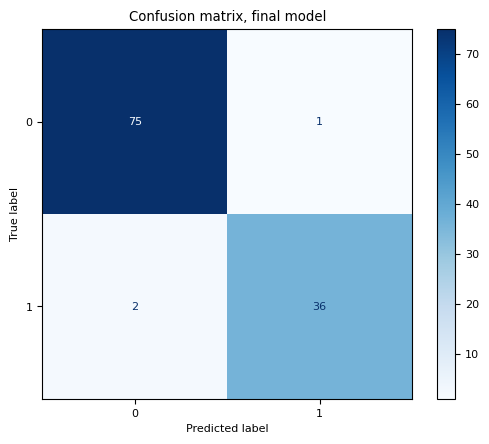

In [47]:
# Final model confusion matrix
final_cm = confusion_matrix(y_test, final_pred)

final_cm_disp = ConfusionMatrixDisplay(confusion_matrix = final_cm,
                                       display_labels = final_model.classes_)
final_cm_disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion matrix, final model')
plt.show()

Ultimately very few false negatives (2) and even fewer false positives (1) out of 114 cases.